In [1]:
import pandas as pd
import numpy as np
import warnings
import time
warnings.filterwarnings("ignore")

from sklearn.experimental import enable_halving_search_cv

from sklearn.model_selection import (
    StratifiedKFold, train_test_split,
    GridSearchCV, RandomizedSearchCV, HalvingGridSearchCV
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
)
from sklearn.base import BaseEstimator, TransformerMixin

import optuna
from optuna.samplers import TPESampler
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

class FrequencyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, cols=None):
        self.cols = cols
        self.freq_maps = {}

    def fit(self, X, y=None):
        if self.cols is None:
            self.cols = list(X.columns)
        for col in self.cols:
            self.freq_maps[col] = X[col].value_counts(normalize=True)
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col in self.cols:
            X_copy[col] = X_copy[col].map(self.freq_maps[col])
            X_copy[col] = X_copy[col].fillna(np.mean(list(self.freq_maps[col].values)))
        return X_copy

    def get_feature_names_out(self, input_features=None):
        return np.array(self.cols)

# DecisionTreeClassifier

In [2]:
FILE_PATH = 'https://media.githubusercontent.com/media/taysumova/urfu_ml/refs/heads/main/data_sources/train.csv'

df = pd.read_csv(FILE_PATH, index_col='id')

In [3]:
df_sample = df.sample(n=1_500_000, random_state=42)

X = df_sample.drop("Response", axis=1)
y = df_sample["Response"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    train_size=1_000_000,
    test_size=500_000,
    stratify=y,
    random_state=42
)

print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")
print(f"Class balance in train:\n{y_train.value_counts(normalize=True)}")

Train shape: (1000000, 10)
Test shape: (500000, 10)
Class balance in train:
Response
0    0.876795
1    0.123205
Name: proportion, dtype: float64


In [4]:
high_card_cols = ['Region_Code', 'Policy_Sales_Channel']
bool_cols = ['Gender', 'Vehicle_Damage']
ord_cols = ['Vehicle_Age']

preprocessor = ColumnTransformer(
    transformers=[
        ("high_cat", FrequencyEncoder(cols=high_card_cols), high_card_cols),
        ("bool", OneHotEncoder(drop='first', sparse_output=False, dtype=np.int32), bool_cols),
        ("ord", OrdinalEncoder(
            categories=[['< 1 Year', '1-2 Year', '> 2 Years']],
            dtype=np.int32
        ), ord_cols),
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)

base_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(class_weight='balanced', random_state=42))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [5]:
def evaluate_pipeline(pipeline, X_train, X_test, y_train, y_test, name):
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]

    metrics = {
        'Method': name,
        'Precision': precision_corrected(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_proba)
    }
    cm = confusion_matrix(y_test, y_pred)
    return metrics, cm

# Обход возможного ZeroDivision в случае отсутствия предсказанных классов
def precision_corrected(y_true, y_pred):
    try:
        return precision_score(y_true, y_pred)
    except:
        return 0.0

PARAM_GRID = {
    'classifier__max_depth': [3, 5, 7, 10],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 5]
}

In [6]:
results = []
conf_matrices = {}

### GridSearchCV

In [7]:
print("Запуск GridSearchCV...")
start_time = time.time()

grid_search = GridSearchCV(
    base_pipeline,
    PARAM_GRID,
    cv=cv,
    scoring='f1',
    n_jobs=-1,
    verbose=0
)
grid_search.fit(X_train, y_train)

elapsed_time = time.time() - start_time

metrics, cm = evaluate_pipeline(grid_search.best_estimator_, X_train, X_test, y_train, y_test, "GridSearchCV")
metrics['Time (sec)'] = round(elapsed_time, 2)

results.append(metrics)
conf_matrices["GridSearchCV"] = cm
print(f"GridSearchCV завершён. Время: {elapsed_time:.2f} сек.")

Запуск GridSearchCV...
GridSearchCV завершён. Время: 117.31 сек.


### RandomizedSearchCV

In [8]:
print("Запуск RandomizedSearchCV...")
start_time = time.time()

random_search = RandomizedSearchCV(
    base_pipeline,
    param_distributions=PARAM_GRID,
    n_iter=40,
    cv=cv,
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=0
)
random_search.fit(X_train, y_train)

elapsed_time = time.time() - start_time

metrics, cm = evaluate_pipeline(random_search.best_estimator_, X_train, X_test, y_train, y_test, "RandomizedSearchCV")
metrics['Time (sec)'] = round(elapsed_time, 2)

results.append(metrics)
conf_matrices["RandomizedSearchCV"] = cm
print(f"RandomizedSearchCV завершён. Время: {elapsed_time:.2f} сек.")

Запуск RandomizedSearchCV...
RandomizedSearchCV завершён. Время: 114.86 сек.


### Optuna

In [10]:
print("Запуск Optuna...")
start_time = time.time()

def objective_optuna(trial):
    params = {
        'classifier__max_depth': trial.suggest_categorical('classifier__max_depth', [3, 5, 7, 10]),
        'classifier__min_samples_split': trial.suggest_categorical('classifier__min_samples_split', [2, 5, 10]),
        'classifier__min_samples_leaf': trial.suggest_categorical('classifier__min_samples_leaf', [1, 2, 5]),
    }
    model = base_pipeline.set_params(**params)
    scores = []
    for train_idx, val_idx in cv.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        model.fit(X_tr, y_tr)
        preds = model.predict(X_val)
        scores.append(f1_score(y_val, preds))
    return -np.mean(scores)

study = optuna.create_study(sampler=TPESampler(seed=42))
study.optimize(objective_optuna, n_trials=40)

optuna_pipeline = base_pipeline.set_params(**study.best_params)
optuna_pipeline.fit(X_train, y_train)

elapsed_time = time.time() - start_time

metrics, cm = evaluate_pipeline(optuna_pipeline, X_train, X_test, y_train, y_test, "Optuna")
metrics['Time (sec)'] = round(elapsed_time, 2)

results.append(metrics)
conf_matrices["Optuna"] = cm
print(f"Optuna завершён. Время: {elapsed_time:.2f} сек.")

[I 2025-12-12 15:47:43,046] A new study created in memory with name: no-name-c7a477ad-ed0c-4d1a-ad0b-0b5a585a7903


Запуск Optuna...


[I 2025-12-12 15:47:53,410] Trial 0 finished with value: -0.4395751110889874 and parameters: {'classifier__max_depth': 5, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 1}. Best is trial 0 with value: -0.4395751110889874.
[I 2025-12-12 15:48:03,186] Trial 1 finished with value: -0.4395751110889874 and parameters: {'classifier__max_depth': 5, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 1}. Best is trial 0 with value: -0.4395751110889874.
[I 2025-12-12 15:48:10,546] Trial 2 finished with value: -0.4336048885278168 and parameters: {'classifier__max_depth': 3, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 2}. Best is trial 0 with value: -0.4395751110889874.
[I 2025-12-12 15:48:24,648] Trial 3 finished with value: -0.43813214656611554 and parameters: {'classifier__max_depth': 10, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 2}. Best is trial 0 with value: -0.4395751110889874.
[I 2025-12-12 15:48:38,71

Optuna завершён. Время: 409.84 сек.


### Hyperopt

In [11]:
print("Запуск Hyperopt...")
start_time = time.time()

# Фиксированные списки
MAX_DEPTH_LIST = [3, 5, 7, 10]
MIN_SPLIT_LIST = [2, 5, 10]
MIN_LEAF_LIST = [1, 2, 5]

def objective_hyperopt(params):
    model = base_pipeline.set_params(**{
        'classifier__max_depth': MAX_DEPTH_LIST[params['max_depth_idx']],
        'classifier__min_samples_split': MIN_SPLIT_LIST[params['min_split_idx']],
        'classifier__min_samples_leaf': MIN_LEAF_LIST[params['min_leaf_idx']],
    })
    scores = []
    for train_idx, val_idx in cv.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        model.fit(X_tr, y_tr)
        preds = model.predict(X_val)
        scores.append(f1_score(y_val, preds))
    return {'loss': -np.mean(scores), 'status': STATUS_OK}

space = {
    'max_depth_idx': hp.choice('max_depth_idx', range(len(MAX_DEPTH_LIST))),
    'min_split_idx': hp.choice('min_split_idx', range(len(MIN_SPLIT_LIST))),
    'min_leaf_idx': hp.choice('min_leaf_idx', range(len(MIN_LEAF_LIST))),
}

trials = Trials()
best = fmin(
    fn=objective_hyperopt,
    space=space,
    algo=tpe.suggest,
    max_evals=40,
    trials=trials,
    rstate=np.random.default_rng(42)
)

# Восстанавливаем параметры
best_params = {
    'classifier__max_depth': MAX_DEPTH_LIST[best['max_depth_idx']],
    'classifier__min_samples_split': MIN_SPLIT_LIST[best['min_split_idx']],
    'classifier__min_samples_leaf': MIN_LEAF_LIST[best['min_leaf_idx']],
}

hyperopt_pipeline = base_pipeline.set_params(**best_params)
hyperopt_pipeline.fit(X_train, y_train)

elapsed_time = time.time() - start_time

metrics, cm = evaluate_pipeline(hyperopt_pipeline, X_train, X_test, y_train, y_test, "Hyperopt")
metrics['Time (sec)'] = round(elapsed_time, 2)

results.append(metrics)
conf_matrices["Hyperopt"] = cm
print(f"Hyperopt завершён. Время: {elapsed_time:.2f} сек.")

Запуск Hyperopt...
100%|██████████| 40/40 [06:52<00:00, 10.31s/trial, best loss: -0.4395795808756377]
Hyperopt завершён. Время: 414.65 сек.


### HalvingGridSearchCV

In [12]:
print("Запуск HalvingGridSearchCV...")
start_time = time.time()

halving_search = HalvingGridSearchCV(
    base_pipeline,
    PARAM_GRID,
    cv=cv,
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=0
)
halving_search.fit(X_train, y_train)

elapsed_time = time.time() - start_time

metrics, cm = evaluate_pipeline(halving_search.best_estimator_, X_train, X_test, y_train, y_test, "HalvingGridSearchCV")
metrics['Time (sec)'] = round(elapsed_time, 2)

results.append(metrics)
conf_matrices["HalvingGridSearchCV"] = cm
print(f"HalvingGridSearchCV завершён. Время: {elapsed_time:.2f} сек.")

Запуск HalvingGridSearchCV...
HalvingGridSearchCV завершён. Время: 46.26 сек.


In [13]:
results_df = pd.DataFrame(results)
print("СВОДКА РЕЗУЛЬТАТОВ")
print("="*60)
print(results_df.round(4))

СВОДКА РЕЗУЛЬТАТОВ
                Method  Precision  Recall      F1  ROC-AUC  Time (sec)
0         GridSearchCV     0.2882  0.9075  0.4375   0.8392      117.31
1   RandomizedSearchCV     0.2882  0.9075  0.4375   0.8392      114.86
2               Optuna     0.2882  0.9075  0.4375   0.8392      409.84
3             Hyperopt     0.2882  0.9075  0.4375   0.8392      414.65
4  HalvingGridSearchCV     0.2882  0.9075  0.4375   0.8392       46.26


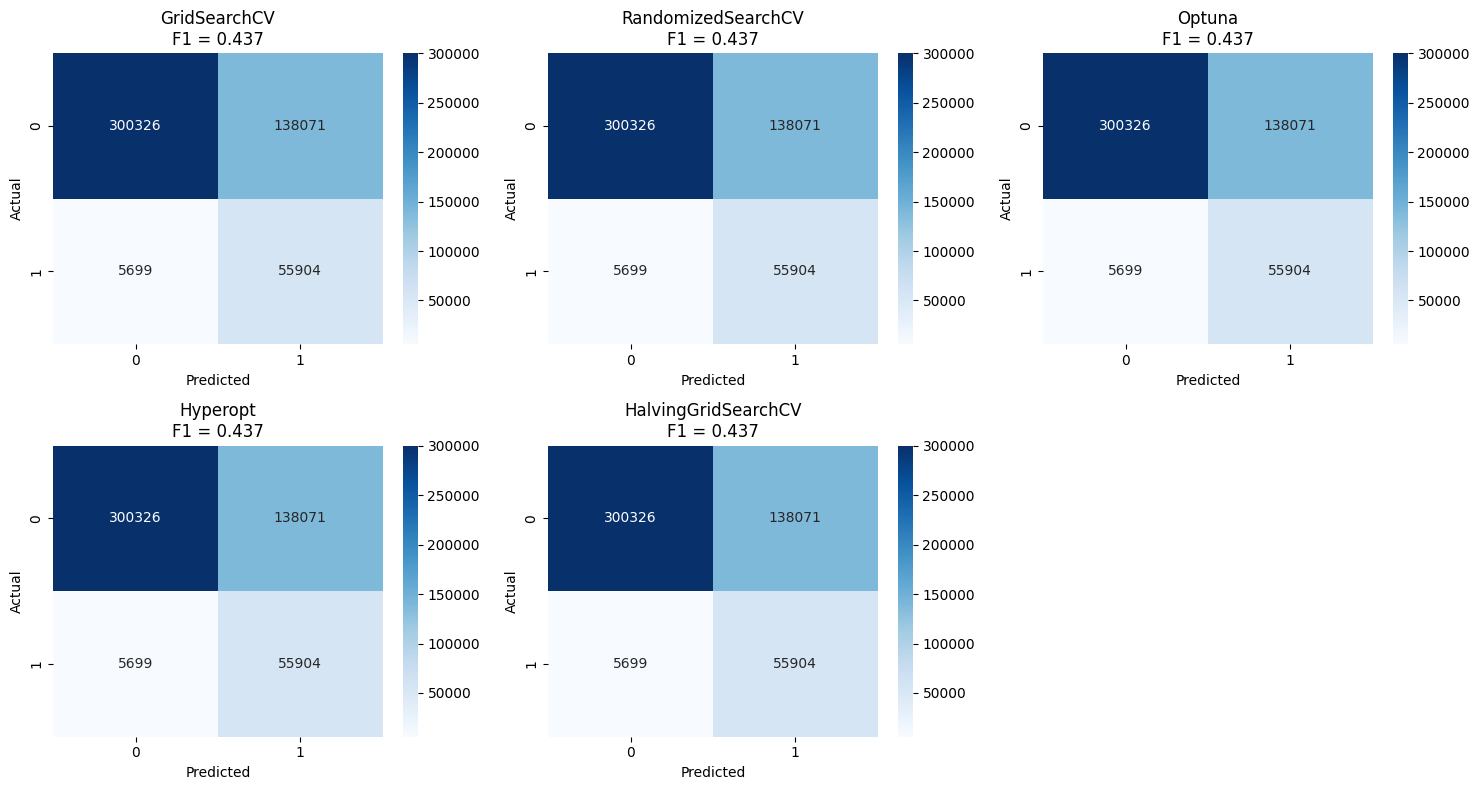

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

methods = list(conf_matrices.keys())
n = len(methods)
cols = 3
rows = (n + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
axes = axes.flatten() if n > 1 else [axes]

for i, method in enumerate(methods):
    cm = conf_matrices[method]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    f1_val = results_df.loc[results_df['Method'] == method, 'F1'].values[0]
    axes[i].set_title(f'{method}\nF1 = {f1_val:.3f}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

## Выводы:

- Модель очень хорошо находит True Positives - Recall = 0.91
- Но также очень много False Positives - Precision = 0.29

**Обоснование выбора F1-score**: для задачи предсказания отклика на предложение доп. страховки оптимальная метрика для подбора гиперпараметров - F1-score, так как она фокусируются на качестве предсказания положительного класса (Response = 1) и устойчива к дисбалансу.

**Обоснование одинаковых результатов**:
- Все методы оптимизации почти равнозначны
- Пространство гиперпараметров очень маленькое
- Возможно переобчение модели

**Итог гипероптимизации:**
- Базовый уровень - RandomizedSearchCV
- Продвинутый уровень - HalvingGridSearchCV

**Возникающие проблемы:**
- Дерево решений плохо работает с несбалансированными данными и склонно к переобучению
- Оптимизация гиперпараметров не дала существенного улучшения, за исключением небольшого роста ROC-AUC у Optuna/Hyperopt, но ценой большего времени